In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import adjusted_rand_score, silhouette_score

import os
os.chdir('../')


from tgmm import GMMInitializer, dynamic_figsize, plot_gmm
from TorchGMM.tgmm.gmm import GaussianMixture

# Set random seed for reproducibility
random_state = 0
np.random.seed(random_state)
torch.manual_seed(random_state)

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if device == 'cuda':
    torch.cuda.manual_seed(random_state)
    print('CUDA version:', torch.version.cuda)
    print('Device:', torch.cuda.get_device_name(0))

Using device: cuda
CUDA version: 12.4
Device: NVIDIA GeForce RTX 4060 Laptop GPU


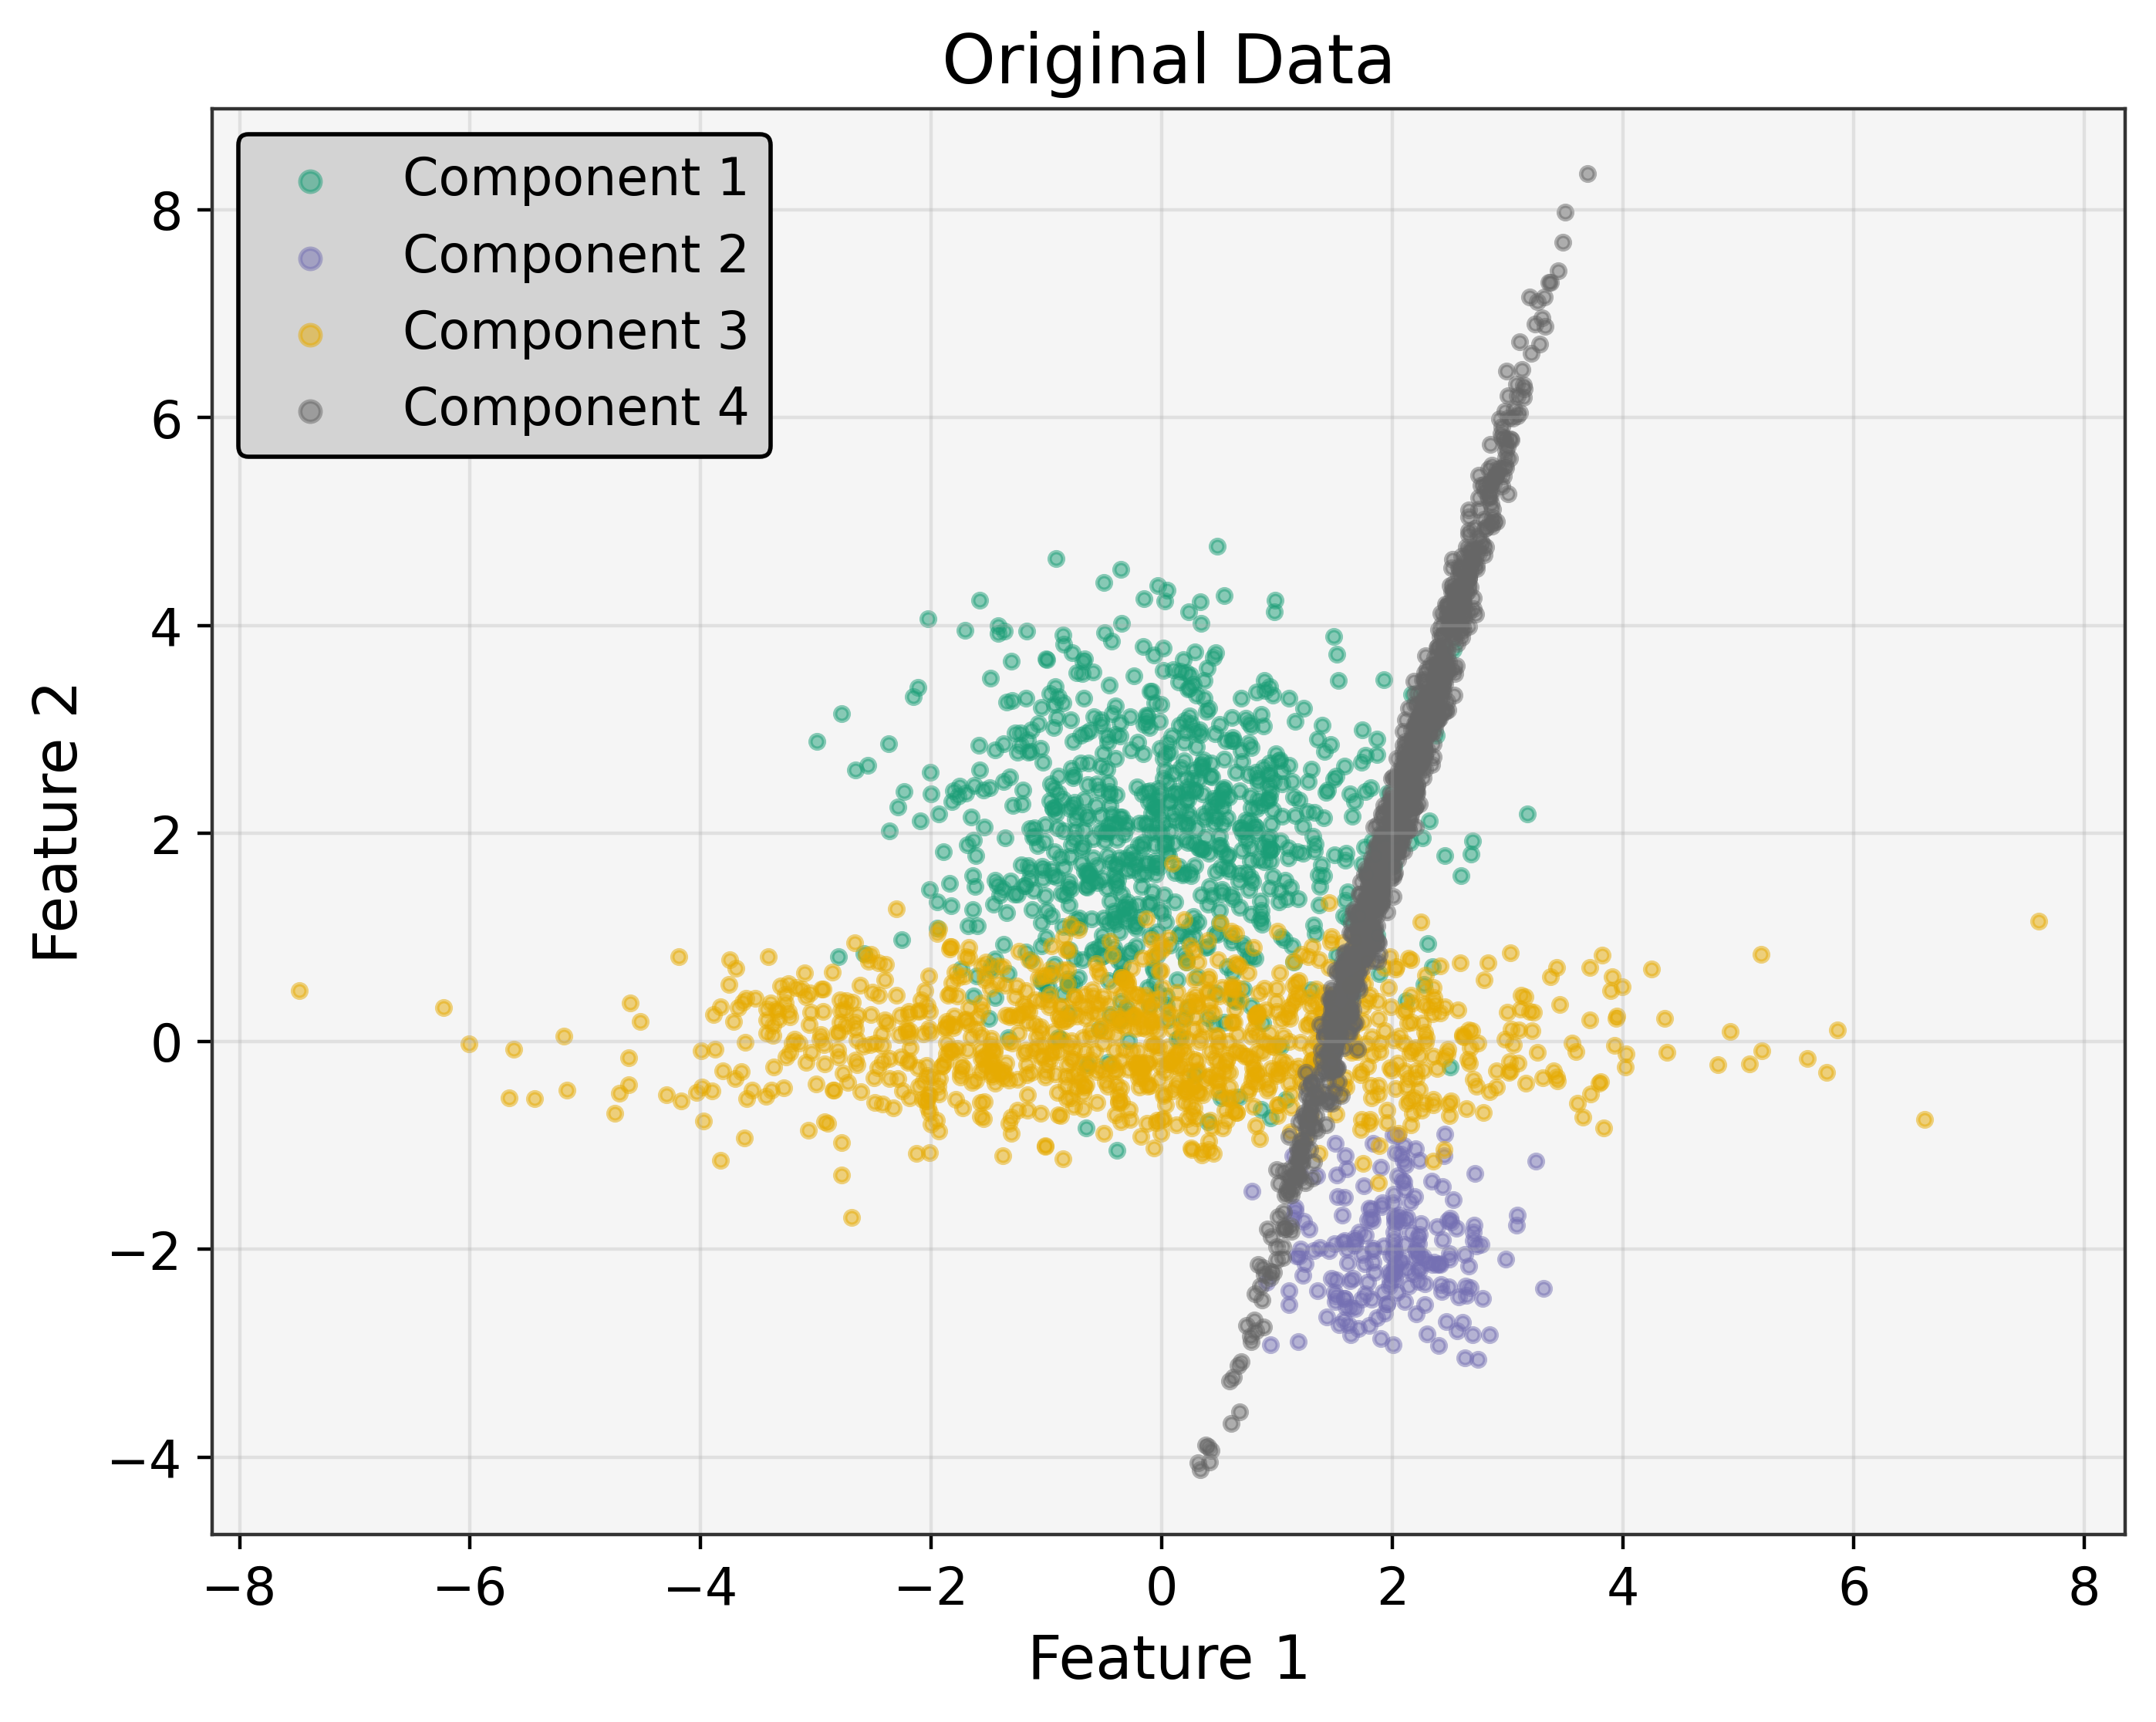

In [78]:
n_samples = [800, 200, 1000, 1000]
centers = [np.array([0, 2]),
           np.array([2, -2]),
           np.array([0, 0]),
           np.array([2, 2])]
covs = [
    1.0 * np.eye(2),                    # spherical covariance
    0.5 * np.eye(2),                    # spherical covariance, fewer points
    np.array([[2, 0], [0, 0.5]]),       # diagonal covariance
    np.array([[0.2, 0.5], [0.5, 2]])    # full covariance
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)
labels = np.concatenate([i * np.ones(n) for i, n in enumerate(n_samples)])
legend_labels = [f'Component {i+1}' for i in range(len(n_samples))]

n_features = X.shape[1]
n_components = len(n_samples)

# Convert to tensor (if needed for further processing)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

plot_gmm(X=X, labels=labels, title='Original Data', legend_labels=legend_labels)
plt.show()

In [79]:
def fit_and_evaluate_gmm(X_tensor, n_components, covariance_type='full', cem=False, random_state=42):
    """Fit a GMM with either EM or CEM and return the model and timing."""
    # Initialize the GMM
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        tol=1e-6,
        reg_covar=1e-6,
        max_iter=1000,
        n_init=5,
        init_params='points',
        random_state=random_state,
        verbose=True,
        device=device,
        cem=cem  # Toggle between EM and CEM
    )
    
    # Time the fitting process
    start_time = time.time()
    gmm.fit(X_tensor)
    end_time = time.time()
    
    return gmm, end_time - start_time

# Fit both models
print("Fitting GMM using standard EM algorithm...")
gmm_em, time_em = fit_and_evaluate_gmm(X_tensor, n_components, cem=False)

print("\nFitting GMM using Classification EM (CEM) algorithm...")
gmm_cem, time_cem = fit_and_evaluate_gmm(X_tensor, n_components, cem=True)

# Print basic comparison
print("\n----- Performance Comparison -----")
print(f"EM:  Time: {time_em:.2f}s, Iterations: {gmm_em.n_iter_}, Log-likelihood: {gmm_em.lower_bound_:.2f}")
print(f"CEM: Time: {time_cem:.2f}s, Iterations: {gmm_cem.n_iter_}, Log-likelihood: {gmm_cem.lower_bound_:.2f}")

Fitting GMM using standard EM algorithm...
[InitRun 0] Iter 0, lower bound: -3.80971
[InitRun 0] Iter 10, lower bound: -3.19473
[InitRun 0] Iter 20, lower bound: -3.17760
[InitRun 0] Iter 30, lower bound: -3.15982
[InitRun 0] Iter 40, lower bound: -3.15908
[InitRun 0] Converged at iteration 41, lower bound=-3.15908
[InitRun 1] Iter 0, lower bound: -3.80971
[InitRun 1] Iter 10, lower bound: -3.19473
[InitRun 1] Iter 20, lower bound: -3.17760
[InitRun 1] Iter 30, lower bound: -3.15982
[InitRun 1] Iter 40, lower bound: -3.15908
[InitRun 1] Converged at iteration 41, lower bound=-3.15908
[InitRun 2] Iter 0, lower bound: -3.80971
[InitRun 2] Iter 10, lower bound: -3.19473
[InitRun 2] Iter 20, lower bound: -3.17760
[InitRun 2] Iter 30, lower bound: -3.15982
[InitRun 2] Iter 40, lower bound: -3.15908
[InitRun 2] Converged at iteration 41, lower bound=-3.15908
[InitRun 3] Iter 0, lower bound: -3.80971
[InitRun 3] Iter 10, lower bound: -3.19473
[InitRun 3] Iter 20, lower bound: -3.17760
[InitRu

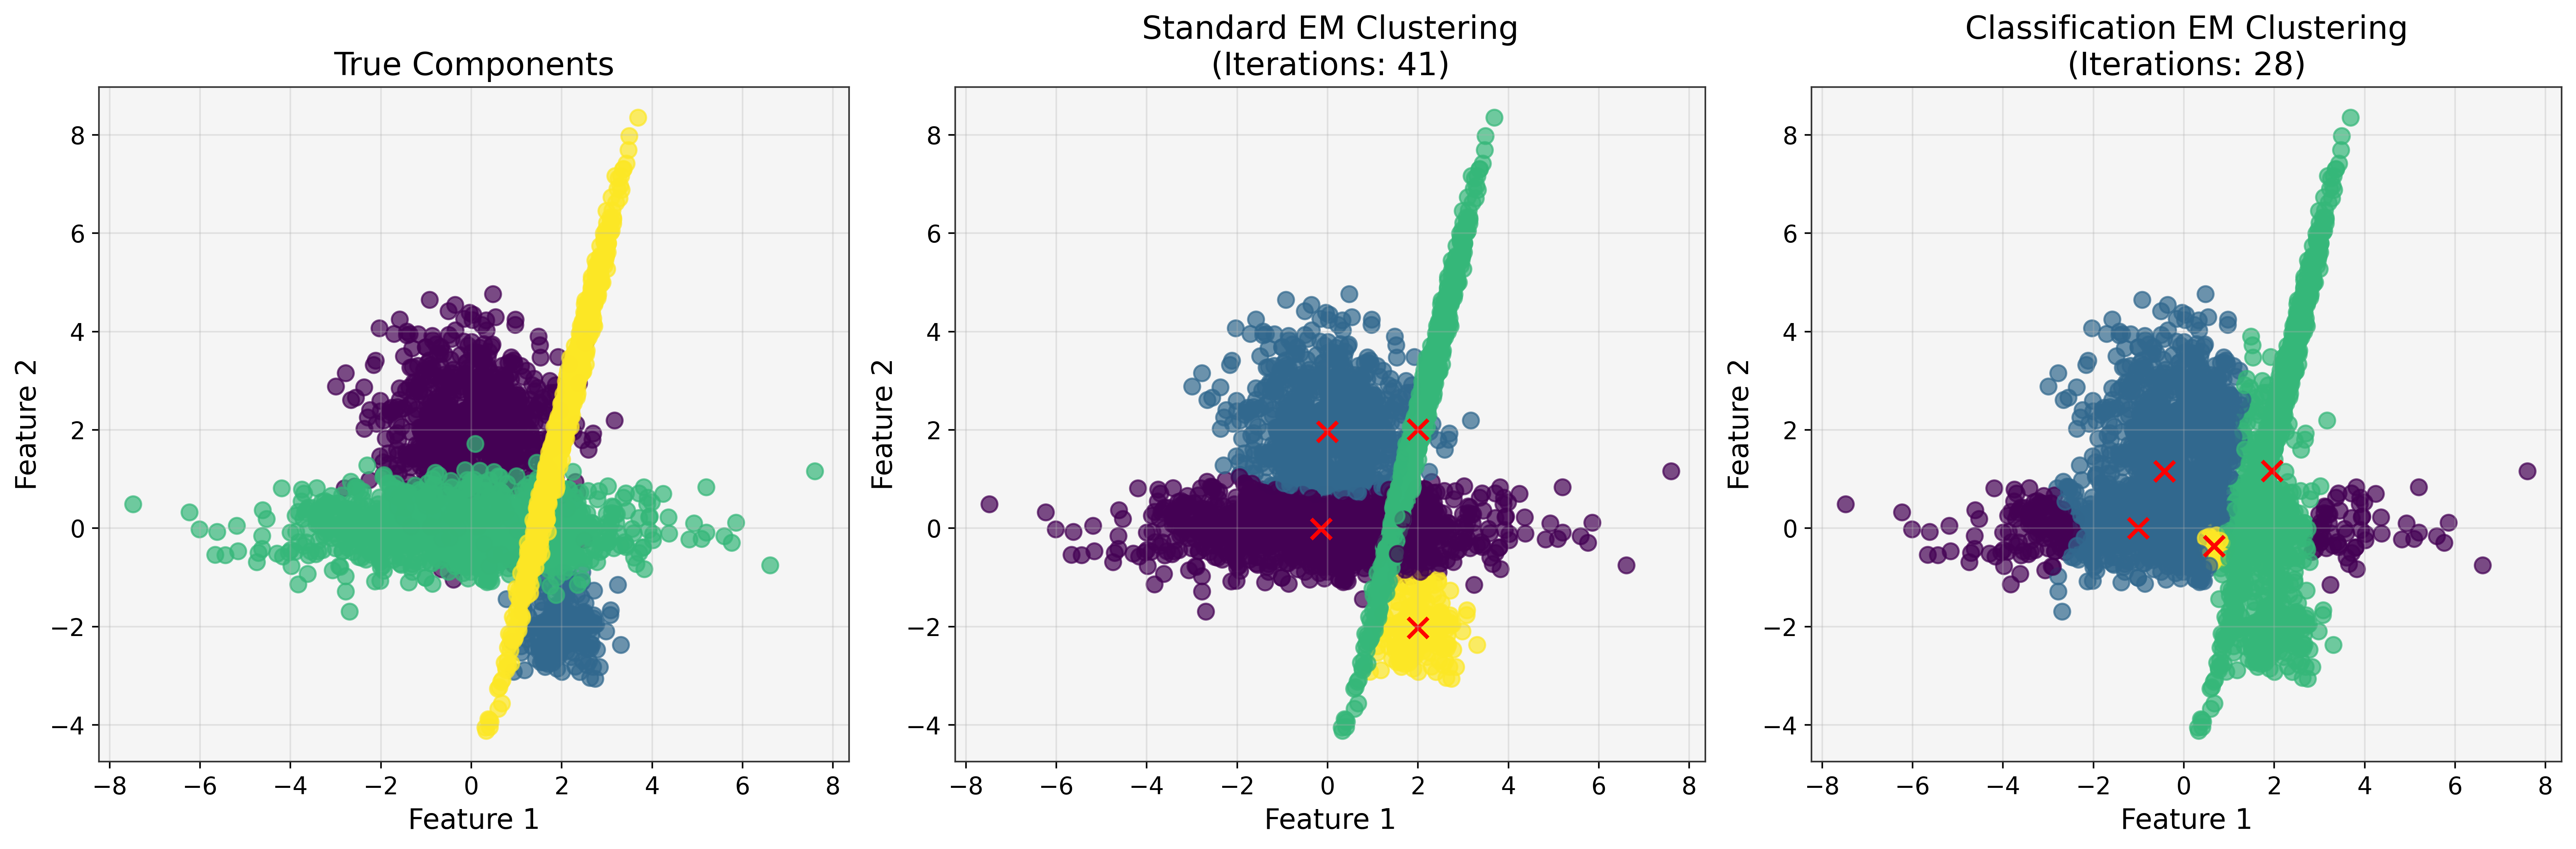

Adjusted Rand Index (higher is better):
  EM:  0.8114
  CEM: 0.3653

Silhouette Score (higher is better):
  EM:  0.2040
  CEM: -0.0298


In [80]:
# Get predictions from both models
y_pred_em = gmm_em.predict(X_tensor).cpu().numpy()
y_pred_cem = gmm_cem.predict(X_tensor).cpu().numpy()

# Create a function to plot the results
def plot_clustering_results(X, true_labels, pred_labels_em, pred_labels_cem, gmm_em, gmm_cem):
    """Plot the clustering results for both EM and CEM algorithms."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot true labels
    axes[0].scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', alpha=0.7)
    axes[0].set_title('True Components')
    axes[0].set_xlabel('Feature 1')
    axes[0].set_ylabel('Feature 2')
    axes[0].grid(alpha=0.3)
    
    # Plot EM results
    axes[1].scatter(X[:, 0], X[:, 1], c=pred_labels_em, cmap='viridis', alpha=0.7)
    
    # Plot ellipses for EM
    means_em = gmm_em.means_.cpu().detach().numpy()
    for i, mean in enumerate(means_em):
        axes[1].scatter(mean[0], mean[1], c='red', s=100, marker='x')
        
    axes[1].set_title(f'Standard EM Clustering\n(Iterations: {gmm_em.n_iter_})')
    axes[1].set_xlabel('Feature 1')
    axes[1].set_ylabel('Feature 2')
    axes[1].grid(alpha=0.3)
    
    # Plot CEM results
    axes[2].scatter(X[:, 0], X[:, 1], c=pred_labels_cem, cmap='viridis', alpha=0.7)
    
    # Plot ellipses for CEM
    means_cem = gmm_cem.means_.cpu().detach().numpy()
    for i, mean in enumerate(means_cem):
        axes[2].scatter(mean[0], mean[1], c='red', s=100, marker='x')
        
    axes[2].set_title(f'Classification EM Clustering\n(Iterations: {gmm_cem.n_iter_})')
    axes[2].set_xlabel('Feature 1')
    axes[2].set_ylabel('Feature 2')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_clustering_results(X, labels, y_pred_em, y_pred_cem, gmm_em, gmm_cem)

# Compute some evaluation metrics
print("Adjusted Rand Index (higher is better):")
print(f"  EM:  {adjusted_rand_score(labels, y_pred_em):.4f}")
print(f"  CEM: {adjusted_rand_score(labels, y_pred_cem):.4f}")

print("\nSilhouette Score (higher is better):")
print(f"  EM:  {silhouette_score(X, y_pred_em):.4f}")
print(f"  CEM: {silhouette_score(X, y_pred_cem):.4f}")

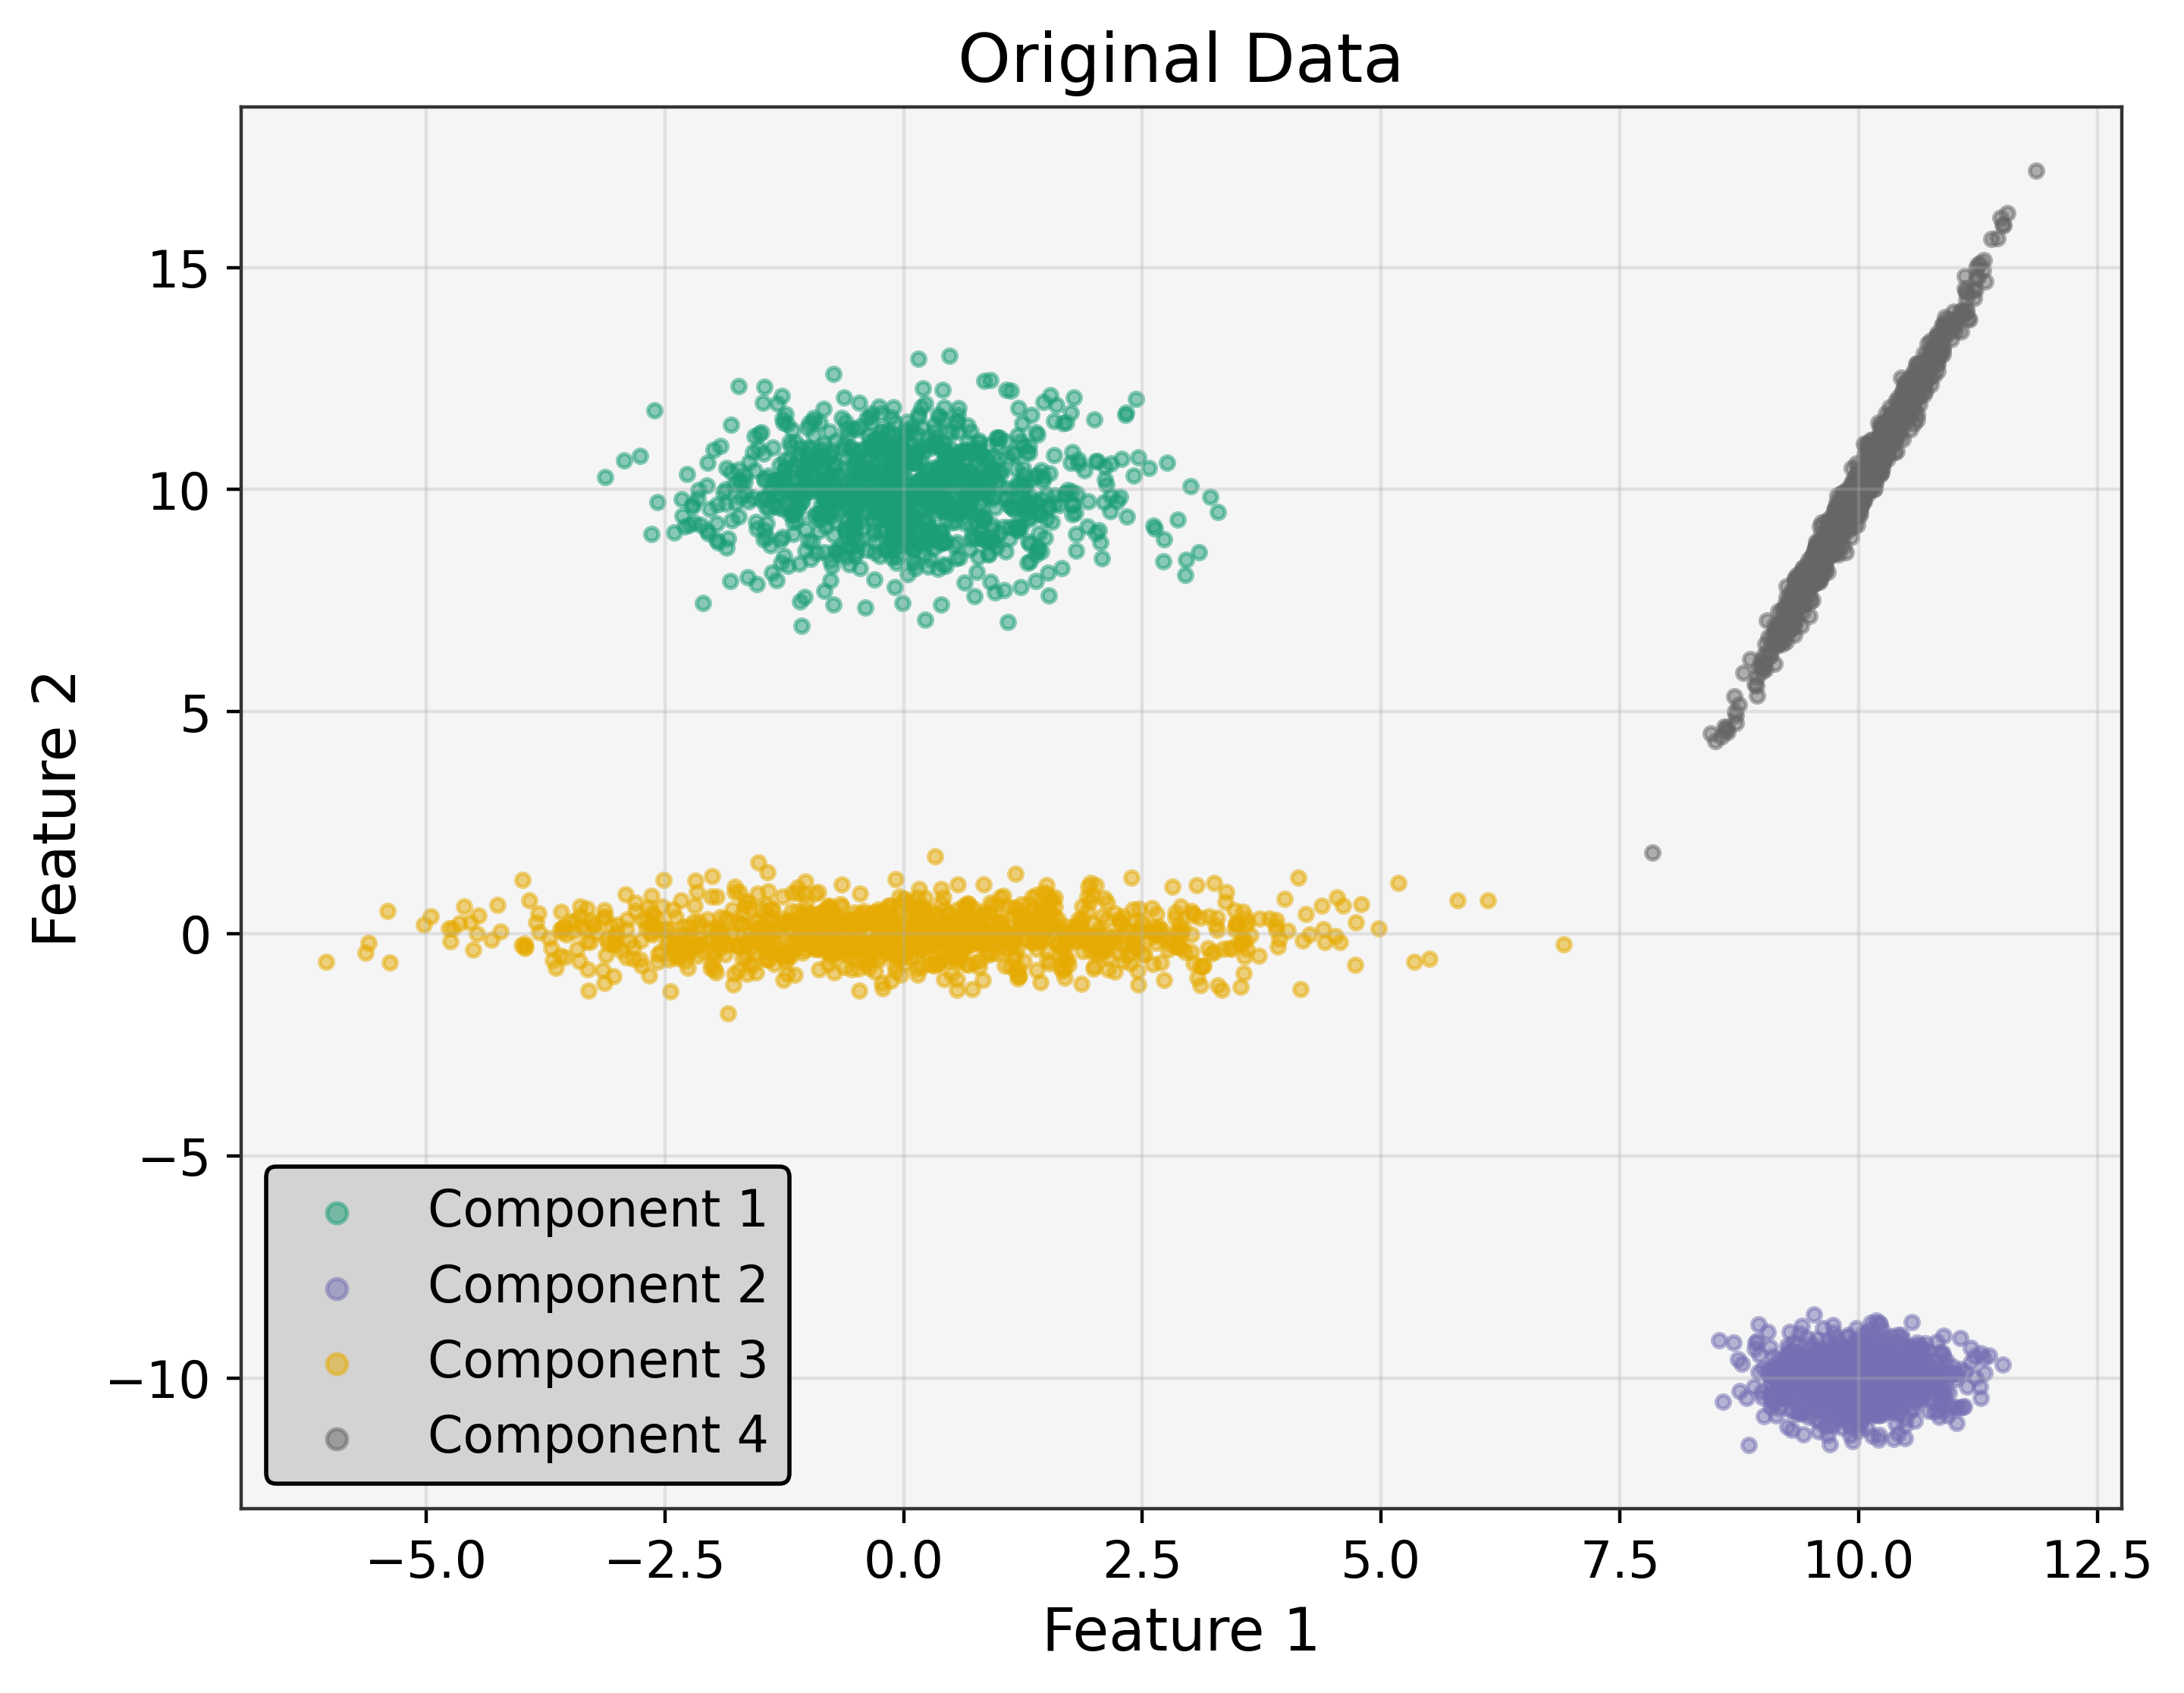

In [81]:
n_samples = [1000, 1000, 1000, 1000]
centers = [np.array([0, 10]),
           np.array([10, -10]),
           np.array([0, 0]),
           np.array([10, 10])]
covs = [
    1.0 * np.eye(2),                    # spherical covariance
    0.5 * np.eye(2),                    # spherical covariance, fewer points
    np.array([[2, 0], [0, 0.5]]),       # diagonal covariance
    np.array([[0.2, 0.5], [0.5, 2]])    # full covariance
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)
labels = np.concatenate([i * np.ones(n) for i, n in enumerate(n_samples)])
legend_labels = [f'Component {i+1}' for i in range(len(n_samples))]

n_features = X.shape[1]
n_components = len(n_samples)

# Convert to tensor (if needed for further processing)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

plot_gmm(X=X, labels=labels, title='Original Data', legend_labels=legend_labels)
plt.show()

In [82]:
def fit_and_evaluate_gmm(X_tensor, n_components, covariance_type='full', cem=False, random_state=42):
    """Fit a GMM with either EM or CEM and return the model and timing."""
    # Initialize the GMM
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        tol=1e-6,
        reg_covar=1e-6,
        max_iter=1000,
        n_init=5,
        init_params='random',
        random_state=random_state,
        verbose=True,
        device=device,
        cem=cem  # Toggle between EM and CEM
    )
    
    # Time the fitting process
    start_time = time.time()
    gmm.fit(X_tensor)
    end_time = time.time()
    
    return gmm, end_time - start_time

# Fit both models
print("Fitting GMM using standard EM algorithm...")
gmm_em, time_em = fit_and_evaluate_gmm(X_tensor, n_components, cem=False)

print("\nFitting GMM using Classification EM (CEM) algorithm...")
gmm_cem, time_cem = fit_and_evaluate_gmm(X_tensor, n_components, cem=True)

# Print basic comparison
print("\n----- Performance Comparison -----")
print(f"EM:  Time: {time_em:.2f}s, Iterations: {gmm_em.n_iter_}, Log-likelihood: {gmm_em.lower_bound_:.2f}")
print(f"CEM: Time: {time_cem:.2f}s, Iterations: {gmm_cem.n_iter_}, Log-likelihood: {gmm_cem.lower_bound_:.2f}")

Fitting GMM using standard EM algorithm...
[InitRun 0] Iter 0, lower bound: -4.58323
[InitRun 0] Iter 10, lower bound: -3.39467
[InitRun 0] Converged at iteration 11, lower bound=-3.39467
[InitRun 1] Iter 0, lower bound: -4.58323
[InitRun 1] Iter 10, lower bound: -3.39467
[InitRun 1] Converged at iteration 11, lower bound=-3.39467
[InitRun 2] Iter 0, lower bound: -4.58323
[InitRun 2] Iter 10, lower bound: -3.39467
[InitRun 2] Converged at iteration 11, lower bound=-3.39467
[InitRun 3] Iter 0, lower bound: -4.58323
[InitRun 3] Iter 10, lower bound: -3.39467
[InitRun 3] Converged at iteration 11, lower bound=-3.39467
[InitRun 4] Iter 0, lower bound: -4.58323
[InitRun 4] Iter 10, lower bound: -3.39467
[InitRun 4] Converged at iteration 11, lower bound=-3.39467

Fitting GMM using Classification EM (CEM) algorithm...
[InitRun 0] Iter 0, lower bound: -4.45679
[InitRun 0] Iter 10, lower bound: -3.39467
[InitRun 0] Converged at iteration 11, lower bound=-3.39467
[InitRun 1] Iter 0, lower bound

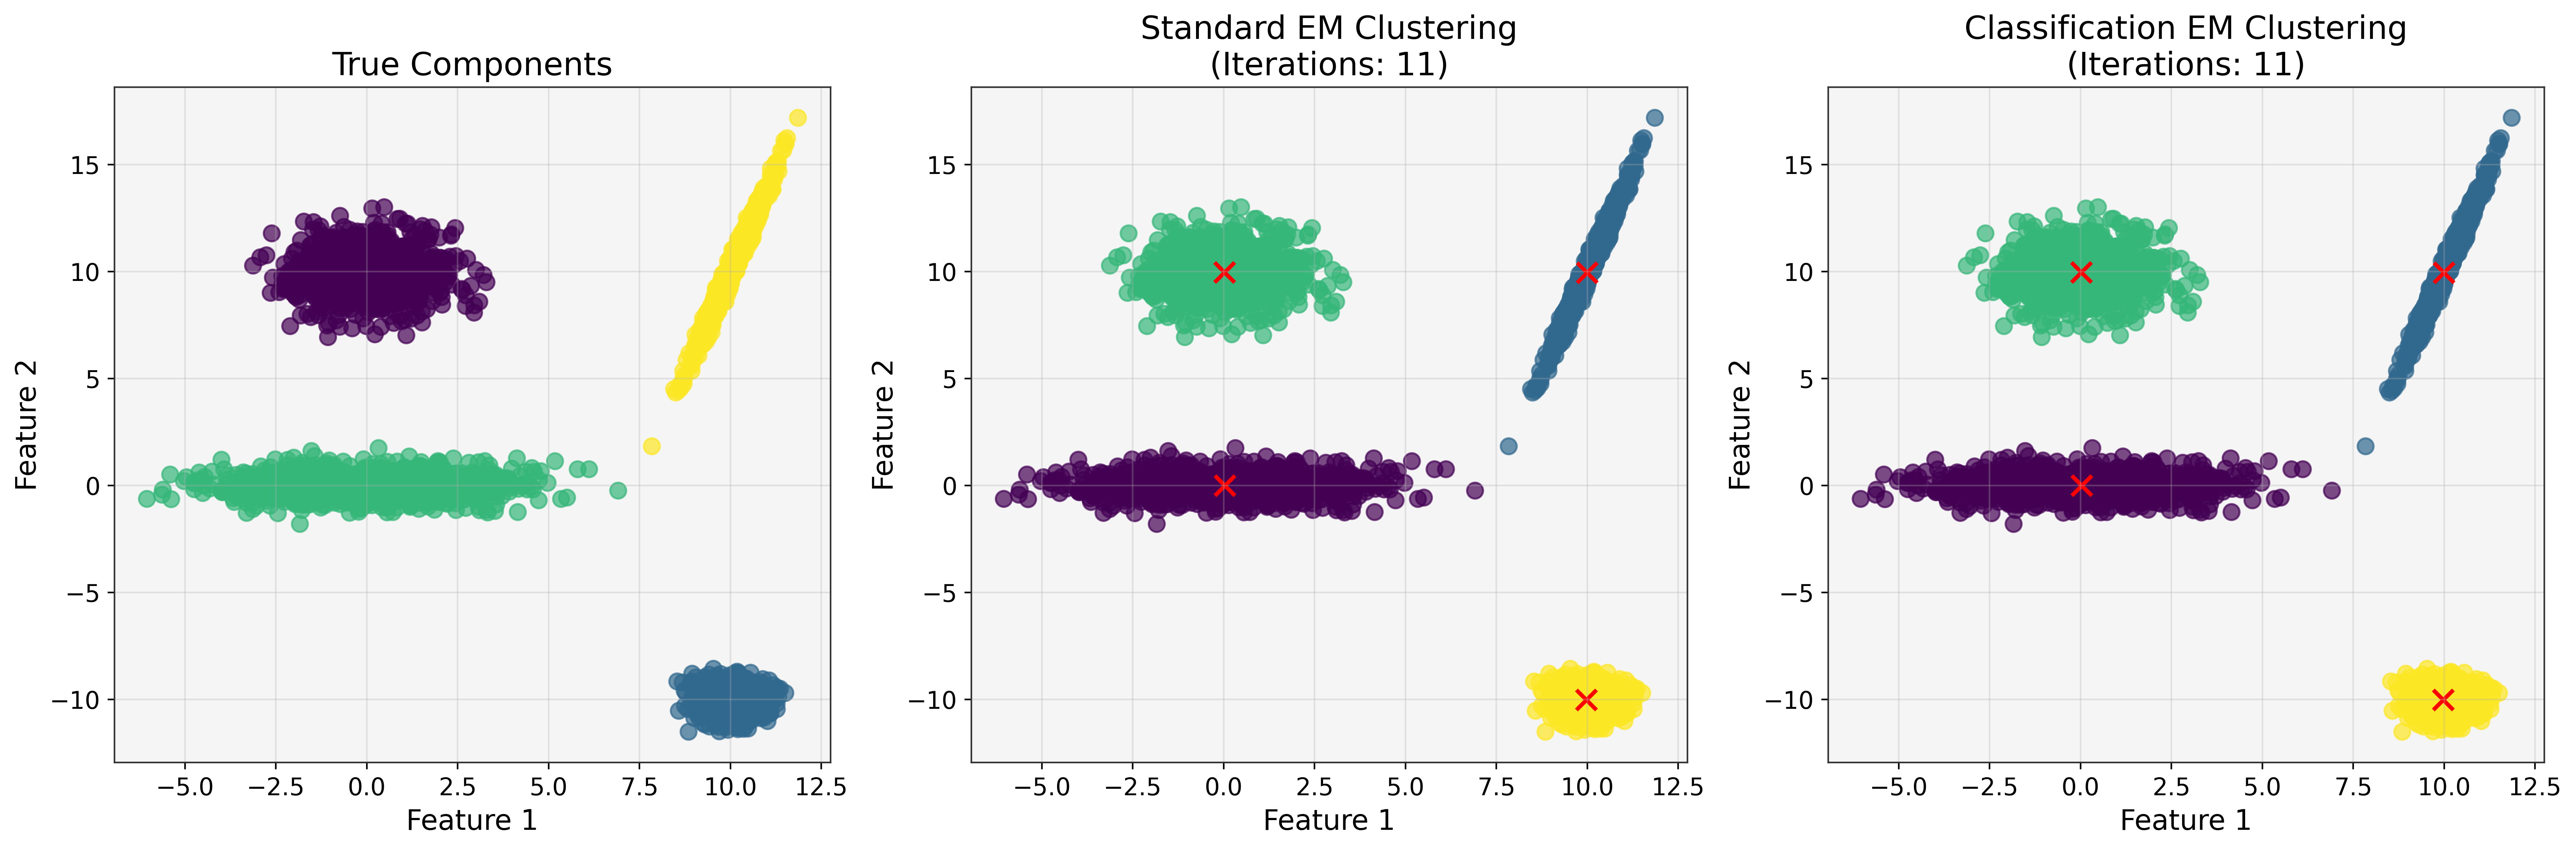

Adjusted Rand Index (higher is better):
  EM:  1.0000
  CEM: 1.0000

Silhouette Score (higher is better):
  EM:  0.8210
  CEM: 0.8210


In [83]:
# Get predictions from both models
y_pred_em = gmm_em.predict(X_tensor).cpu().numpy()
y_pred_cem = gmm_cem.predict(X_tensor).cpu().numpy()

# Create a function to plot the results
def plot_clustering_results(X, true_labels, pred_labels_em, pred_labels_cem, gmm_em, gmm_cem):
    """Plot the clustering results for both EM and CEM algorithms."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot true labels
    axes[0].scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', alpha=0.7)
    axes[0].set_title('True Components')
    axes[0].set_xlabel('Feature 1')
    axes[0].set_ylabel('Feature 2')
    axes[0].grid(alpha=0.3)
    
    # Plot EM results
    axes[1].scatter(X[:, 0], X[:, 1], c=pred_labels_em, cmap='viridis', alpha=0.7)
    
    # Plot ellipses for EM
    means_em = gmm_em.means_.cpu().detach().numpy()
    for i, mean in enumerate(means_em):
        axes[1].scatter(mean[0], mean[1], c='red', s=100, marker='x')
        
    axes[1].set_title(f'Standard EM Clustering\n(Iterations: {gmm_em.n_iter_})')
    axes[1].set_xlabel('Feature 1')
    axes[1].set_ylabel('Feature 2')
    axes[1].grid(alpha=0.3)
    
    # Plot CEM results
    axes[2].scatter(X[:, 0], X[:, 1], c=pred_labels_cem, cmap='viridis', alpha=0.7)
    
    # Plot ellipses for CEM
    means_cem = gmm_cem.means_.cpu().detach().numpy()
    for i, mean in enumerate(means_cem):
        axes[2].scatter(mean[0], mean[1], c='red', s=100, marker='x')
        
    axes[2].set_title(f'Classification EM Clustering\n(Iterations: {gmm_cem.n_iter_})')
    axes[2].set_xlabel('Feature 1')
    axes[2].set_ylabel('Feature 2')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_clustering_results(X, labels, y_pred_em, y_pred_cem, gmm_em, gmm_cem)

# Compute some evaluation metrics
print("Adjusted Rand Index (higher is better):")
print(f"  EM:  {adjusted_rand_score(labels, y_pred_em):.4f}")
print(f"  CEM: {adjusted_rand_score(labels, y_pred_cem):.4f}")

print("\nSilhouette Score (higher is better):")
print(f"  EM:  {silhouette_score(X, y_pred_em):.4f}")
print(f"  CEM: {silhouette_score(X, y_pred_cem):.4f}")